WARNING!  This script is not idiot-proof.  There are no safeguards to stop your printer from damaging itself.
Designed for an Ender 3.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#routines taken from fullcontrol.xyz

begin_routine="""G28 ; home axes
M140 S50 ; set bed temp and continue
M105
M104 S210 ; set hotend temp and continue
M190 S50 ; set bed temp and wait
M105
M109 S210  ; set hotend temp and wait
G90 ; absolute coordinates
G21 ; set units to millimeters
M83 ; relative extrusion
M106 S255 ; set fan speed
G0 F8000 X10.0 Y10.0 Z10.0
G1 F250 E20.7876
G0 F250 Z50.0
G0 F8000 Z0.3
M220 S100 ; set speed factor override percentage
M221 S100 ; set extrude factor override percentage
;-----
; END OF STARTING PROCEDURE
;-----

"""
end_routine="""
;-----
; START OF ENDING PROCEDURE
;-----
G10 ; retract
G91 ; relative coordinates
G0 Z20 F8000 ; drop bed
G90 ; absolute coordinates
M106 S0 ; set fan speed
M140 S0 ; set bed temp and continue
M104 S0 ; set hotend temp and continue
M84 X Y E ;Disable all steppers but Z
"""

In [3]:
def points_to_gcode(coords):
    gcode_text=begin_routine
    extrude_per_mm=2*.01176332385  #nothing special about this number.  I tinkered until it worked.
    num_coords=coords.shape[0]
    
    gcode_text+='G0 F500 X91.400 Y91.400 Z0.20\n'    
    gcode_text+='G91\n'
    for i in range(num_coords-1):
        x1=coords[i,0]
        y1=coords[i,1]
        x2=coords[i+1,0]
        y2=coords[i+1,1]
        length=((x2-x1)**2+(y2-y1)**2)**.5
        extrusion=round(length*extrude_per_mm,4)
        gcode_text+=f'G1 X{round(x2-x1,4)} Y{round(y2-y1,4)} E{extrusion}\n'
    gcode_text+=end_routine
    return gcode_text

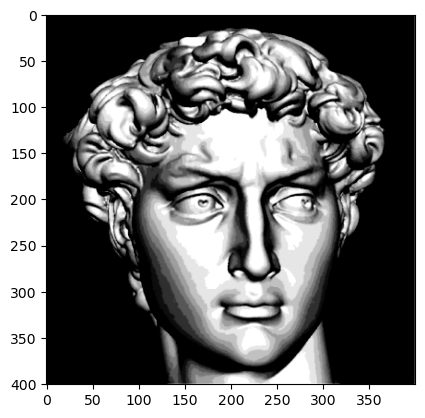

In [4]:
plot_width_mm=51  #physical sizes of the print
plot_height_mm=51
plot_delta_mm=.3  #gap distance between each grid line

depth_image = plt.imread("david.bmp")/255.0   #use a blank image to generate a lenticular lens sheet
image_height, image_width = depth_image.shape[0:2]

plt.imshow(depth_image)

In [5]:
#"sigma" is the distance the path deviates from the 
#normal grid line.Based on brightness of the depth image
plot_points=[]
for y in np.arange(0,plot_height_mm,2*plot_delta_mm):
    
    for x in np.arange(0,plot_width_mm,plot_delta_mm):
        plot_sigma_mm=.5*plot_delta_mm*depth_image[int(x*(image_width/plot_width_mm))-1,int(y*(image_height/plot_height_mm))-1,0]
        plot_points.append([x+plot_delta_mm,y+plot_sigma_mm])
        
    for x in np.arange(plot_width_mm,0,-plot_delta_mm):
        plot_sigma_mm=.5*plot_delta_mm*depth_image[int(x*(image_width/plot_width_mm))-1,int(y*(image_height/plot_height_mm))-1,0]
        plot_points.append([x,y+plot_delta_mm+plot_sigma_mm])


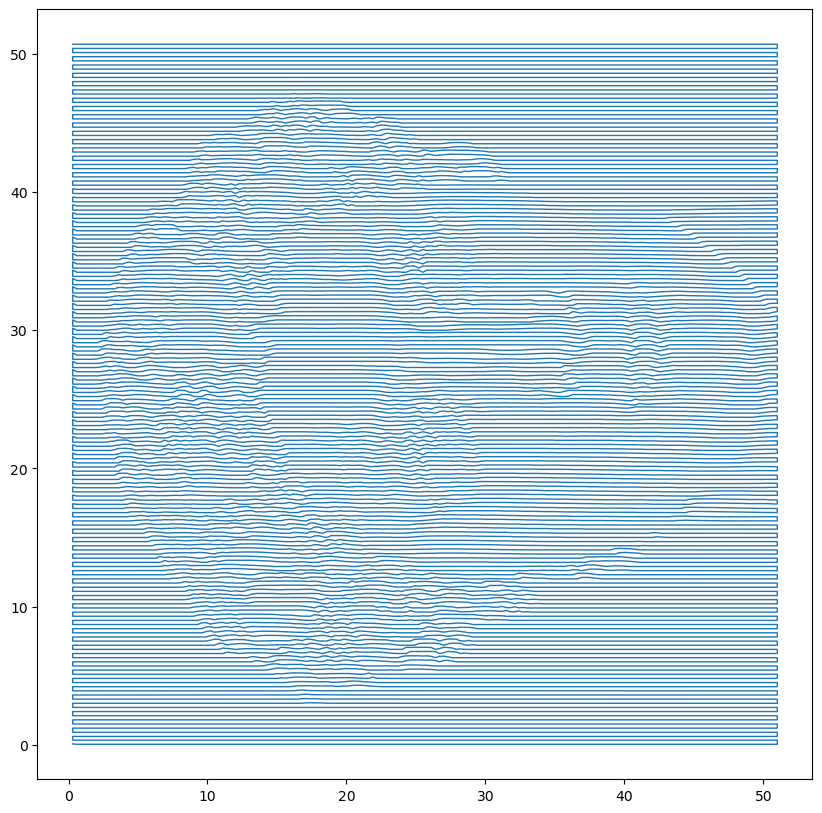

In [6]:
plot_points=np.array(plot_points)   #preview plot of expected extruder path.  
                                    #Should look like the album art from Joy Division's "Unknown Pleaures"
plot_points=plot_points.round(decimals=4)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.plot(plot_points[0:30000,0],plot_points[0:30000,1],linewidth=1)
plt.show()

In [7]:
g_code_text=points_to_gcode(plot_points)
with open('david.gcode', 'w') as f:
    f.write(g_code_text)